# Урок 6. ETL (PYTHON + SQL)

Применим знания на практике: с помощью pandahouse попробуем выгрузить нужные данные из ClickHouse и проанализируем их в python. 

На этот раз новый датасет, содержащий информацию об объявлениях на Airbnb в Лондоне 🇬🇧.

`ldn_listings` – информация о жилье, включая полные описания, характеристики и средние оценки в отзывах; поскольку столбцов очень много, нужные перечислены в текстах самих задач

In [15]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import numpy as np
import pandahouse as ph
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(16,6)}, style='whitegrid')

### 1

Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings.

In [2]:
import pandahouse as ph
connection = {'database':'default',
              'host': 'http://clickhouse.beslan.pro:8080',
              'user':'student', 
              'password':'dpo_python_2020'
             }

In [25]:
q1 = """
     SELECT COUNT(*) AS rows
       FROM ldn_listings
     """

In [29]:
q_test1 = ph.read_clickhouse(query=q1, connection=connection)
q_test1

,rows
0,85207


### 2

Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:

· price – цена за ночь  
· room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)  
Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

Пример результирующей таблицы:

In [ ]:
+-----------------+------------+
| room_type       | price      |
+-----------------+------------+
| Private room    |         65 | 
| Entire home/apt |        100 | 
+-----------------+------------+

Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.

In [28]:
q2 = """
     SELECT room_type,
            toFloat32OrNull(replaceRegexpAll(price, '[$,]','')) AS price
       FROM ldn_listings 
      ORDER BY id
      LIMIT 1000     
      """

In [30]:
q_test2 = ph.read_clickhouse(query=q2, connection=connection)
q_test2

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [31]:
q_test2.dtypes

room_type     object
price        float32
dtype: object

In [39]:
df2 = q_test2.groupby("room_type").quantile(q=0.75).reset_index()

In [40]:
df2.query('room_type == "Private room"') # df[df['room_type'] == 'Private room']

,room_type,price
2,Private room,70.0


### 3

К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

Давайте построим график рассеивания, который покажет зависимость средней цены от средней оценки в зависимости от типа жилья. Ограничение поставьте на 1000 строк. 

Исходная таблица должна выглядеть так:

In [ ]:
+-----------------+------------+--------------------+
| room_type       | price      |review_scores_rating|
+-----------------+------------+--------------------+
| Private room    |         65 | 96.0               |
| Entire home/apt |        100 | 78.0               |
+-----------------+------------+--------------------+

1. сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)

2. используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)

In [42]:
q3 = """
     SELECT room_type,
            toFloat32OrNull(replaceRegexpAll(price, '[$,]','')) AS price,
            toFloat32OrNull(review_scores_rating) AS review_scores_rating
       FROM ldn_listings 
      WHERE review_scores_rating IS NOT Null
      ORDER BY id
      LIMIT 1000     
      """

In [43]:
q_test3 = ph.read_clickhouse(query=q3, connection=connection)
q_test3

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [44]:
df3 = q_test3.groupby("room_type", as_index=False) \
             .agg({"price": "mean",
                   "review_scores_rating": "mean"})

In [45]:
df3

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


<AxesSubplot:xlabel='price', ylabel='review_scores_rating'>

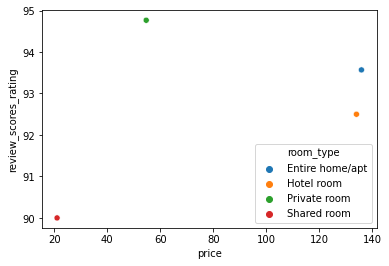

In [46]:
sns.scatterplot(data=df3, x="price", y="review_scores_rating", hue="room_type")

### 4

Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:

· host_id – идентификатор хозяина (уникальный)  
· host_verifications – какими способами хост подтвердил свой профиль

Затем обработайте столбец host_verifications:

1. В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 

"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']

2. Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [47]:
q4 = '''
     SELECT DISTINCT host_id,
            host_verifications
       FROM ldn_listings
      WHERE experiences_offered != 'none' 
     '''

In [48]:
q_test4 = ph.read_clickhouse(query=q4, connection=connection)
q_test4

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [60]:
df4 = q_test4.host_verifications.apply(lambda x: x.strip('[]').replace("'", '').split(', ')) \
                             .explode() \
                             .value_counts()

In [61]:
df4

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

### 5

Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.

Пример трёх строк результирующей таблицы: в районе City of London для 7 объявлений указан тип впечатления business, для одного – family.

In [ ]:
+------------------------+---------------------+-------------------+
| neighbourhood_cleansed | experiences_offered | experiences_count |
+------------------------+---------------------+-------------------+
| City of London         | business            |                 7 |
| City of London         | family              |                 1 |
| City of London         | romantic            |                 1 |
+------------------------+---------------------+-------------------+

Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

In [74]:
q5 = '''
     SELECT neighbourhood_cleansed,
            experiences_offered,
            COUNT(*) AS experiences_count
       FROM ldn_listings
      WHERE experiences_offered != 'none'
      GROUP BY neighbourhood_cleansed,
              experiences_offered
      ORDER bY experiences_count DESC
      LIMIT 100 
     '''

In [75]:
q_test5 = ph.read_clickhouse(query=q5, connection=connection)
q_test5

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [76]:
q_test5 = q_test5.pivot(index="neighbourhood_cleansed", columns="experiences_offered", values="experiences_count")
q_test5.head()

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0


<AxesSubplot:xlabel='experiences_offered', ylabel='neighbourhood_cleansed'>

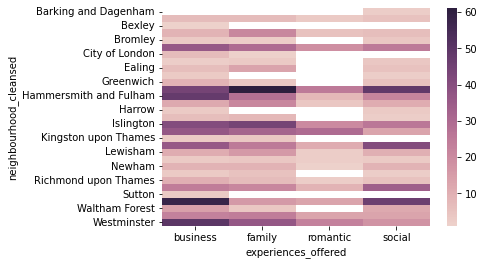

In [77]:
sns.heatmap(data=q_test5,cmap=sns.cubehelix_palette(as_cmap=True))

### 6

Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:

· room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)  
· price – цена за ночь   
· experiences_offered – вид доступного впечатления (оставить не 'none')  

Пример части результирующей таблицы:

+-----------------+------------+
| room_type       | price_corr |
+-----------------+------------+
| Private room    |         65 |
| Entire home/apt |        100 |
| Entire home/apt |        ... |
+-----------------+------------+

· room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)  
· price – цена за ночь     
· experiences_offered – вид доступного впечатления (оставить не 'none')  

Далее постройте два графика, используя distplot из библиотеки seaborn:

· На первом отобразите исходные распределения цен для каждого типа жилья  
· На втором – логарифмированные значения (np.log())

In [3]:
q6 = '''
     SELECT toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_corr,
            room_type
       FROM ldn_listings
      WHERE experiences_offered != 'none'
     '''

In [4]:
q_test6 = ph.read_clickhouse(query=q6, connection=connection)
q_test6

,price_corr,room_type
0,65.0,Private room
1,100.0,Entire home/apt
2,150.0,Private room
3,45.0,Private room
4,25.0,Private room
...,...,...
1543,100.0,Entire home/apt
1544,125.0,Entire home/apt
1545,185.0,Entire home/apt
1546,110.0,Entire home/apt


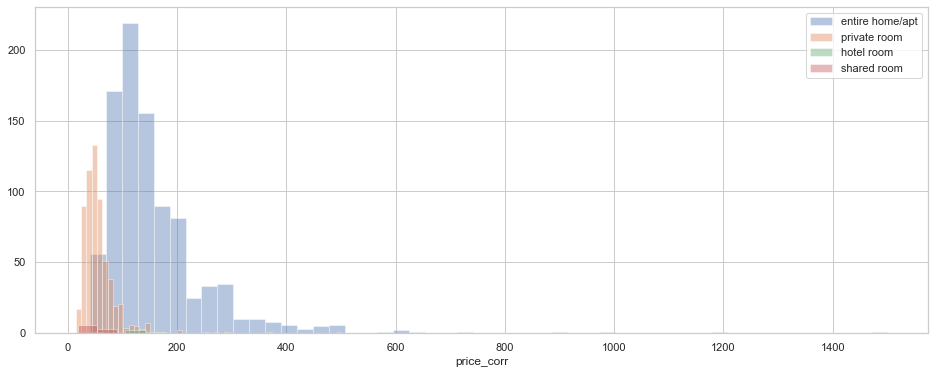

In [16]:
sns.distplot((q_test6.query("room_type == 'Entire home/apt'").price_corr), kde=False, label='entire home/apt')
sns.distplot((q_test6.query("room_type == 'Private room'").price_corr), kde=False, label='private room')
sns.distplot((q_test6.query("room_type == 'Hotel room'").price_corr), kde=False, label='hotel room')
sns.distplot((q_test6.query("room_type == 'Shared room'").price_corr), kde=False, label='shared room')
plt.legend()
plt.show()

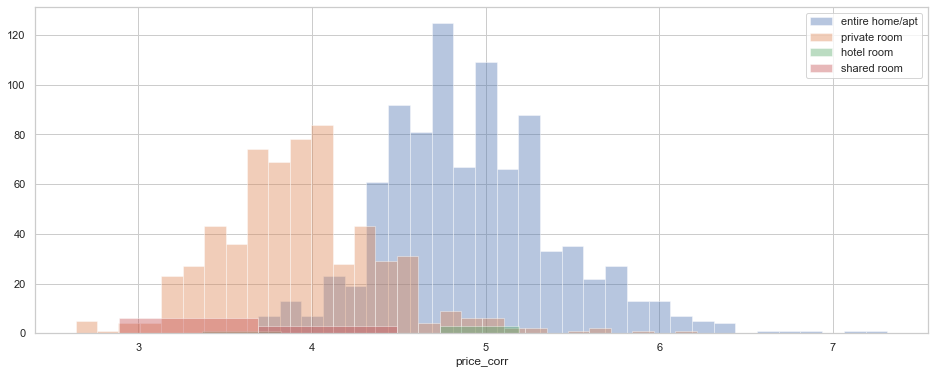

In [17]:
sns.distplot(np.log(q_test6.query("room_type == 'Entire home/apt'").price_corr), kde=False, label='entire home/apt')
sns.distplot(np.log(q_test6.query("room_type == 'Private room'").price_corr), kde=False, label='private room')
sns.distplot(np.log(q_test6.query("room_type == 'Hotel room'").price_corr), kde=False, label='hotel room')
sns.distplot(np.log(q_test6.query("room_type == 'Shared room'").price_corr), kde=False, label='shared room')
plt.legend()
plt.show()

### 7

Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

· room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)  
· price – цена за ночь  
· first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")  
Ограничение поставьте на 1000 строк.

Пример результирующей таблицы:

In [ ]:
+-----------------+------------+------------+
| room_type       | price_corr |first_review|
+-----------------+------------+------------+
| Private room    |         65 | 2010-03-23 |
| Entire home/apt |        100 | 2012-01-01 |
+-----------------+------------+------------+

Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

Пример датафрейма, который будет служить основой для графика:

In [ ]:
+-----------------+------------+------------+
| room_type       | avg_price  | year       |
+-----------------+------------+------------+
| Private room    |         54 | 2010       |
| Entire home/apt |        168 | 2012       |
+-----------------+------------+------------+

Hints: line plot; удалите последние 6 символов у значений в столбце даты, чтобы получить год, например, с помощью применения lambda-функции .

In [25]:
q7 = '''
     SELECT room_type,
            toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_corr,
            first_review
       FROM ldn_listings
      WHERE first_review > '2010-01-01'
      LIMIT 1000
     '''

In [30]:
q_test7 = ph.read_clickhouse(query=q7, connection=connection)
q_test7

,room_type,price_corr,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [31]:
q_test7['first_review_year'] = q_test7.first_review.apply(lambda x: x[:4])

In [32]:
q_test7

,room_type,price_corr,first_review,first_review_year
0,Private room,65.0,2010-08-18,2010
1,Entire home/apt,300.0,2011-03-21,2011
2,Entire home/apt,65.0,2016-03-05,2016
3,Private room,29.0,2010-04-14,2010
4,Private room,100.0,2010-10-16,2010
...,...,...,...,...
995,Private room,45.0,2012-11-07,2012
996,Private room,51.0,2013-03-18,2013
997,Entire home/apt,79.0,2012-09-17,2012
998,Entire home/apt,110.0,2012-09-24,2012


<AxesSubplot:xlabel='first_review_year', ylabel='price_corr'>

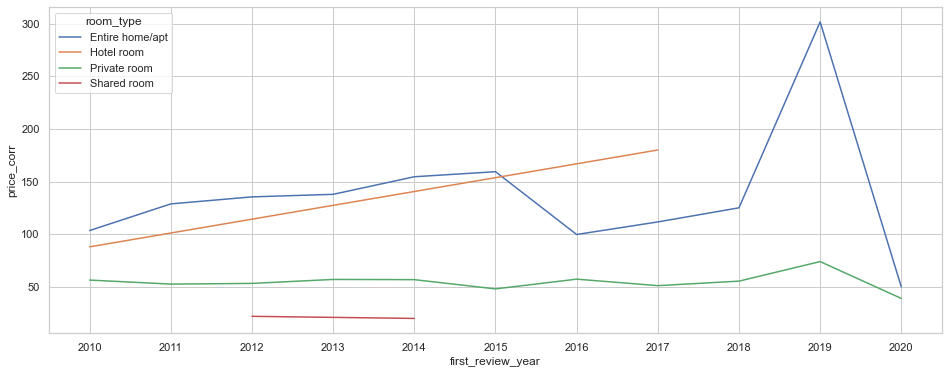

In [34]:
q_test7 = q_test7.groupby(['first_review_year', 'room_type'], as_index=False) \
                 .agg({'price_corr': 'mean'})
sns.lineplot(data=q_test7, hue='room_type', x='first_review_year', y='price_corr')